# SPRINT 6 Final Project 
# Introduction
---
In this project we'll be taking a look at competing taxi companies' data. We'll look for and identify any trends within the data to get an understanding of passenger habit. We'll analyze the data to also see if external factors have any affect on rides. 

Here are the datasets we'll be taking a look at:<ol>
1. <a href='https://practicum-content.s3.us-west-1.amazonaws.com/learning-materials/data-analyst-eng/moved_project_sql_result_01.csv'>Taxi Companies</a> Containing:
    - company_name: taxi company name
    - trips_amount: the number of rides for each taxi company on November 15-16, 2017.
    
    <br>
2. <a href='https://practicum-content.s3.us-west-1.amazonaws.com/learning-materials/data-analyst-eng/moved_project_sql_result_04.csv'>Dropoff Data</a> Containing:
    - dropoff_location_name: Chicago neighborhoods where rides ended
    - average_trips: the average number of rides that ended in each neighborhood in November 2017.
    
    <br>
3. <a href='https://practicum-content.s3.us-west-1.amazonaws.com/learning-materials/data-analyst-eng/moved_project_sql_result_07.csv'>For Hypothesis Testing</a>  Containing:
    - start_ts: pickup date and time
    - weather_conditions: weather conditions at the moment the ride started
    - duration_seconds: ride duration in seconds
    
</ol>

The 2 datasets, as A & B above, will be used for our analysis. We will use said datasets to visualize any patterns/trends and identify the top ten cities in terms of drop-offs.


The following hypotheses will be tested:

$H_{0}$ The duration of rides from the the Loop to O'Hare International Airport does not change on rainy Saturdays
<br>
$H_{1}$ The duration of rides from the the Loop to O'Hare International Airport changes on rainy Saturdays


This project consists of:
1. Data Overview
2. Data Analysis
3. Hypotheses Testing
4. Conclusion

<em>Let's get started!</em>

## Data Overview
---

In [2]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np

In [3]:
# Loading datasets and printing for overview
print('Taxi DF:')
taxi_df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/learning-materials/data-analyst-eng/moved_project_sql_result_01.csv')
print(taxi_df.info())
print(taxi_df.head())
print()
print('Dropfoff DF:')
dropoff_df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/learning-materials/data-analyst-eng/moved_project_sql_result_04.csv')
print(dropoff_df.info())
print(dropoff_df.head())

Taxi DF:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
                      company_name  trips_amount
0                        Flash Cab         19558
1        Taxi Affiliation Services         11422
2                 Medallion Leasin         10367
3                       Yellow Cab          9888
4  Taxi Affiliation Service Yellow          9299

Dropfoff DF:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+

In [4]:
#checking for duplicates
print("Taxi df duplicates found: ",taxi_df.duplicated().sum())
print("Dropoff df duplicates found: ", dropoff_df.duplicated().sum())

Taxi df duplicates found:  0
Dropoff df duplicates found:  0


In [7]:
# Chrecking for missing values
print("Taxi df missing values: ", taxi_df.isna().sum()[1])
print("Dropoff df missing values found: ", dropoff_df.isna().sum()[1])

Taxi df missing values:  0
Dropoff df missing values found:  0


/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8850/965521072.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Taxi df missing values: ", taxi_df.isna().sum()[1])
/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8850/965521072.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Dropoff df missing values found: ", dropoff_df.isna().sum()[1])


No issues with the data 👍

## Data Analysis
---

In [8]:
print(dropoff_df.describe())
print(taxi_df.describe())

       average_trips
count      94.000000
mean      599.953728
std      1714.591098
min         1.800000
25%        14.266667
50%        52.016667
75%       298.858333
max     10727.466667
       trips_amount
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000


After verifying the means and quartiles it indicates there is no normal distribution within the dataset. The data seems to be heavily skewed. Let's check out how 'top-heavy' this data is with a couple bar of pie charts.

In [9]:
# Creating variable for top ten dropoff locations for plotting
top_ten_cities = dropoff_df.sort_values(by='average_trips',ascending=False).head(10)
top_shares =pd.Series([element for element in top_ten_cities['average_trips'] / dropoff_df['average_trips'].sum()]) # Shares per individual city in the top ten city list for dropoff
top_labels = top_ten_cities.loc[:,'dropoff_location_name'] # Lables for legend

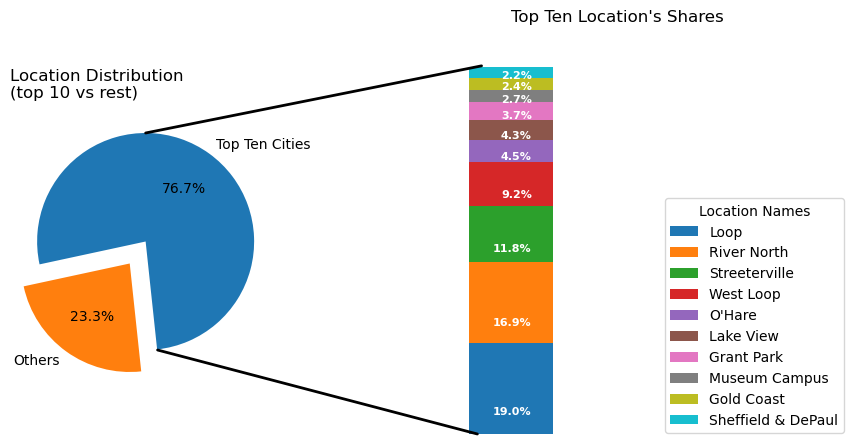

In [10]:
# Loading library that allows to create connecting lines to plots
from matplotlib.patches import ConnectionPatch
# Setting up the subplots
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(7,5))
fig.subplots_adjust(wspace=0)
# Creating variables for pie chart parameters
others_shares = 1 - top_shares.sum()# NON top ten city dropoff total shares
total_shares = [(top_shares.sum()),others_shares]
total_labels = ['Top Ten Cities', 'Others']
explode = [0, 0.25]
angle = -360 * total_shares[1]
wedges, *_ = ax1.pie(total_shares, autopct='%1.1f%%', startangle=angle,
                     labels=total_labels,explode=explode)
ax1.set_title('Location Distribution \n(top 10 vs rest)',loc='left')

# Creating variables for the bar plot
x = 0
bottom_val=1
colors = plt.cm.tab10(range(len(top_shares)))
for share, label, color in zip(top_shares, top_labels, colors):
    # Plot a segment of the bar
    bar = ax2.bar(x, share, bottom=bottom_val,color=color,width=3)
    # Place the label and share percentage in the center of the segment.
    ax2.text(0.004, bottom_val + share/4, f"{share:.1%}",
             ha='right', va='center', color='white', fontsize=8, fontweight='bold')
    bottom_val += share  # update bottom for the next segment

ax2.set_title('Top Ten Location\'s Shares',x=1.24,y=1.05)
ax2.axis('off')
ax2.set_xlim(0.-6,0.5)
ax2.legend(top_labels,loc='lower right',bbox_to_anchor=(2.1,-0.0155),title='Location Names')

# Draw top lines between the two plots

con_top = ConnectionPatch(xyA=(-1.2,1.77), coordsA=ax2.transData,
                      xyB=(0,1), coordsB=ax1.transData, axesA=ax1,
                      axesB=ax2,color='black',linewidth=2)
ax2.add_artist(con_top)

# Draw bottom connecting line
con_bottom = ConnectionPatch(xyA=(-1.3, 1), coordsA=ax2.transData,
                      xyB=(0.11, -1), coordsB=ax1.transData,
                      axesA=ax1, axesB=ax2,color='black', linewidth=2)
ax2.add_artist(con_bottom)

plt.show()

The figure above confirms that over 75% of the total average dropoffs end up in ten areas (as listed in the legend above. The remaining 84 dropoff areas only make up for less than a quarter of the total average trips. 

It would be interesting to analyze the distribution of the pickup areas and start times of those trips that ended with a dropoff in the top ten dropoff areas. This could give us some possible insights on trends to get ahead of the competition.

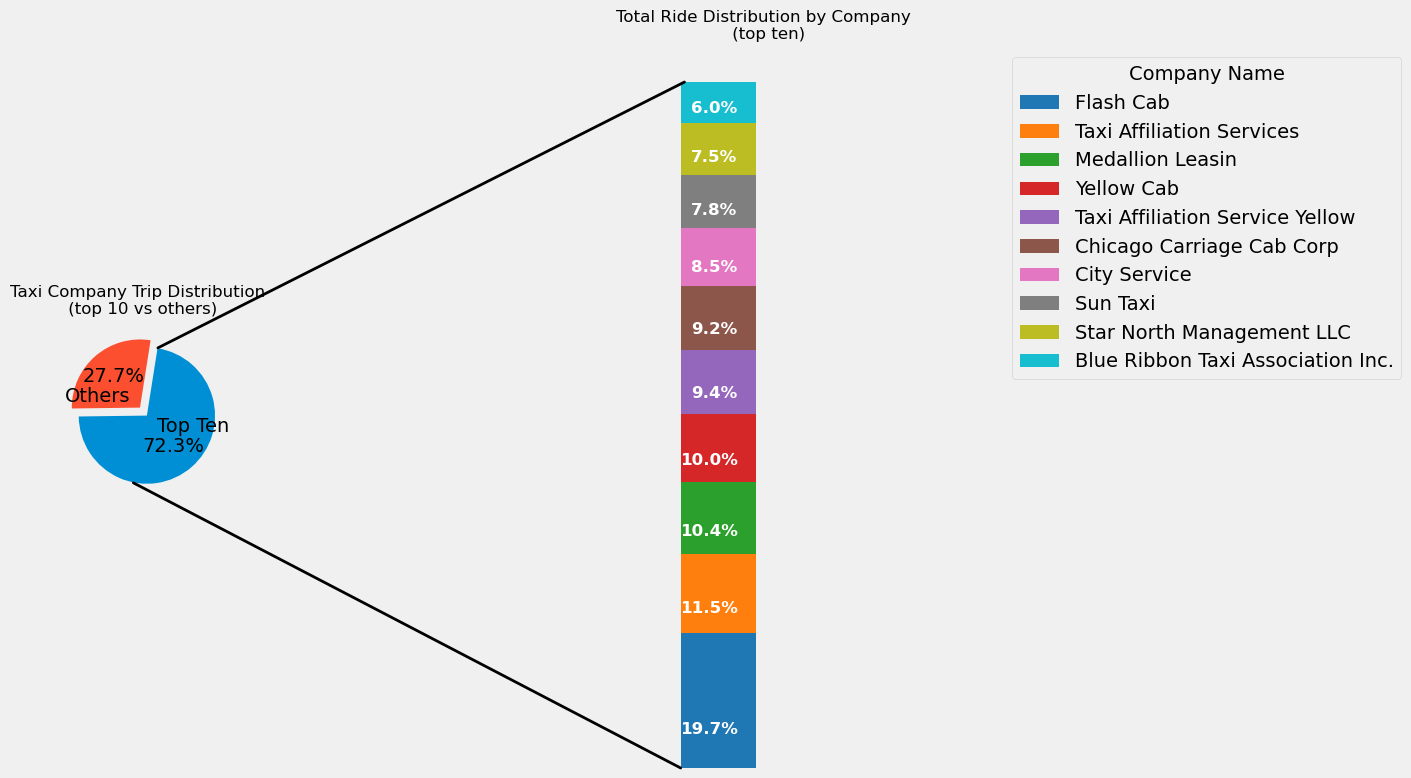

In [23]:
# Creating similar subplots but visualizing taxi company data
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
fig.subplots_adjust(wspace=0.5)
# Isolating the top ten taxi companies by total trips
top_taxis = taxi_df.sort_values(by='trips_amount',ascending=False).head(10)
top_taxi_distribution = [element for element in top_taxis['trips_amount'] / top_taxis['trips_amount'].sum()]
# Adding to get total amount of trips of all companies
total_taxi_trips = taxi_df['trips_amount'].sum()
# Aggregating total amount of trips for top ten taxi companies
top_taxi_trips = top_taxis['trips_amount'].sum()
taxi_marketshare = [
    (top_taxi_trips/total_taxi_trips),(1-(top_taxi_trips/total_taxi_trips))
                                      ]
angle= 250 * taxi_marketshare[0]
explode=(0.15,0.005)
# Selecting style for plot
plt.style.use('fivethirtyeight')
ax1.pie(
    taxi_marketshare,autopct='%1.1f%%',
                     labels=['Top Ten','Others'],labeldistance=0.22
        ,explode=explode, startangle=angle)
ax1.set_title('Taxi Company Trip Distribution \n (top 10 vs others)',fontsize=12)
# Creating bar plot
x=0
height=sum(top_taxi_distribution)
bottom_val=1
colors = plt.cm.tab10(range(len(top_taxi_distribution)))
for share, label, color in zip(top_taxi_distribution, top_taxis['company_name'], colors):
    # Plot a segment of the bar
    bar = ax2.bar(x, share, bottom=bottom_val, width=0.01,color=color)
    # Place the label and share percentage in the center of the segment.
    ax2.text(0.004, bottom_val + share/4, f"{share:.1%}",
             ha='right', va='baseline', color='white', fontsize=12, fontweight='heavy')
    bottom_val += share  # update bottom for the next segment
ax2.set_title('Total Ride Distribution by Company \n (top ten)', fontsize=12)
ax2.set_axis_off()
ax2.legend(top_taxis['company_name'], title='Company Name', bbox_to_anchor=(1.89,1))
ax2.set_xlim(0.001,0.01)

# Draw top lines between the two plots
con_top = ConnectionPatch(xyA=(.26,.88),coordsA=ax1.transData,
                      xyB=(0.0012,2), coordsB=ax2.transData,
                      axesA=ax1,axesB=ax2,color='black',
                       linewidth=2)

ax2.add_artist(con_top)
# Drawing bottom connecting line
con_bottom = ConnectionPatch(xyA=(-0.1, -1.1), coordsA=ax1.transData,
                       xyB=(0.001, 1), coordsB=ax2.transData,
                       axesA=ax1, axesB=ax2,color='black',
                            linewidth=2)
ax2.add_artist(con_bottom)

plt.tight_layout()
plt.show()

The figure showing the distribution of total trips of all the taxi companies in the dataset confirms the top companies control most of the marketshare. About 16% of the taxi companies here account for a little over 72% of the total rides. This is yet another example of the Pareto principle in play.

## Hypotheses Testing
---

$H_0$ The duration of rides from the the Loop to O'Hare International Airport does not change on rainy Saturdays<br>
$H_1$ The duration of rides from the the Loop to O'Hare International Airport changes on rainy Saturdays

In [25]:
# Loading weather dataset for hypothesis testing
df_weather = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/learning-materials/data-analyst-eng/moved_project_sql_result_07.csv')
# Slicing data for testing
df_rain = df_weather[df_weather['weather_conditions']=='Bad']
df_no_rain = df_weather[df_weather['weather_conditions']=='Good'].sample(180) # Taking a 180 element sample for the t-test
# Viewing details
print(df_rain.info())
print(df_no_rain.info())

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 6 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            180 non-null    object 
 1   weather_conditions  180 non-null    object 
 2   duration_seconds    180 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 755 to 734
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            180 non-null    object 
 1   weather_conditions  180 non-null    object 
 2   duration_seconds    180 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.6+ KB
None


In [26]:
# Isolating the duration values for testing
rain_ride_dur = df_rain['duration_seconds']
no_rain_dur = df_no_rain['duration_seconds']
alpha = 0.05
results = st.ttest_rel(no_rain_dur,rain_ride_dur)
print('p-value: ' , results.pvalue)
if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We can\'t reject the null hypothesis')

p-value:  1.1135574627057199e-09
We reject the null hypothesis


We chose to approach this test by comparing the equality of the means of our two paired samples, trips on days with rain and the other without. The alpha was set to 0.05 because we are checking if there is a two-tailed difference between our two sample.

After passing the two samples through our t-test, the results indicate that we reject the null hypothesis. Durations of rides indeed change on rainy Saturdays.

# Conclusion
---

In conclusion, after eview of the dataset we clearly see weather can affect trip durations on rainy Saturdays. This can allow us to prepare for delays and possibly have more drivers on the road to ease pickup delays.

The data showed us the distributions of, not only dropoff location areas, but also the taxi company trips amounts are heavily skewed. The competition of taxi companies are heavy controlled by the top ten companies thus far. Knowing where most of the dropoffs are, and where those pickups are coming from along with the pickup times, will give us a steep advantage on the competition.

Nothing like a good dose of fresh competition to shake things up!